# Solutions -- Homework 3

In [1]:
import numpy as np
freq = np.array([162,267,271,185,111,61,27,8,3,1])

## Problem 1

The Poisson probability mass function is
$$ f(x|\lambda) = \frac{e^{-\lambda}\lambda^x}{x!}$$

The MLE maximizes the log likelihood. The log likelihood for the sample is
\begin{align*}
\log f(\vec{x}) &= \log \prod_{i=1}^n f(x_i|\lambda)\\
&= \sum_{i=1}^n \log f(x_i|\lambda)\\
&= \sum_{i=1}^n (-\lambda + x_i\log \lambda - \log x!)\\
&= -n\lambda + \sum_{i=1}^n(x_i) \log \lambda - \sum_{i=1}^n \log x!
\end{align*}
Differentienting, setting equal to $0$, and solving for $\lambda$, we obtain
$$ \widehat{\lambda} = \bar{X} = \frac{1}{n}\sum_{i=1}^n X_i $$
In other words, the MLE is the sample mean.

We now compute the sample mean for this data.

In [2]:
## number of observations
n = np.sum(freq)

In [3]:
## mean number of deaths = total deaths / number of days
lambda_mle = np.sum(np.arange(freq.size)*freq) / n
lambda_mle

2.156934306569343

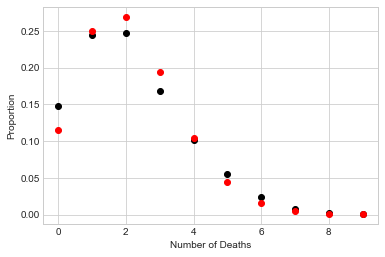

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import poisson

plt.style.use('seaborn-whitegrid')

## proportion of different number of deaths
x = np.arange(freq.size)
plt.plot(x, freq/np.sum(freq), 'o', color='black')
plt.plot(x, poisson.pmf(x, lambda_mle),'o',color='red')
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion");

## Problem 2

The answer to problem 1 used standard notation for the data i.e. $x_1$ was the number of deaths on day 1. Now we let $n_i = $ number of days with $i$ deaths. So
$$n_i = \sum_j \mathbb{1}_{X_j=i}$$

The likelihood is
$$f(\vec{n}|\alpha,\mu_1,\mu_2) = \prod_{i=0}^9 \left(\underbrace{\alpha e^{-\mu_1} \frac{\mu_1^i}{i!} + (1-\alpha)e^{-\mu_2}\frac{\mu_2^i}{i!}}_{\equiv g_i}\right)^{n_i}$$

So the log likelihood is
$$ \log \, f = \sum_{i=0}^9 n_i \log(g_i) $$

The gradient is
$$ \frac{\partial log f}{\partial \alpha} = \sum_{i=0}^9 \frac{n_i}{g_i} \frac{\partial g_i}{\partial \alpha}$$
$$ \frac{\partial log f}{\partial \mu_j} = \sum_{i=0}^9 \frac{n_i}{g_i} \frac{\partial g_i}{\partial \mu_j}$$
for $j=1,2$ and where
$$\frac{\partial g_i}{\partial \alpha} = e^{-\mu_1} \frac{\mu_1^i}{i!} - e^{-\mu_2}\frac{\mu_2^i}{i!}$$
$$\frac{\partial g_i}{\partial \mu_1} = -\alpha e^{-\mu_1} \frac{\mu_1^i}{i!} + \alpha e^{-\mu_1} \frac{\mu_1^{i-1}\mathbb{1}_{i > 0}}{(i-1)!}$$
$$\frac{\partial g_i}{\partial \mu_1} = -(1-\alpha) e^{-\mu_2} \frac{\mu_2^i}{i!} + (1-\alpha) e^{-\mu_2} \frac{\mu_2^{i-1}\mathbb{1}_{i > 0}}{(i-1)!}.$$
Note the indicator functions. These are important for the second terms in the $\partial g_i / \partial \mu_j$ which are $0$ for $i=0$ (because we are differentiating a constant).

We now write functions to implement the log likelihood and gradient. The log likelihood is fairly straightforward.

In [5]:
import scipy

def g(alpha,mu1,mu2,N):
    iis = np.arange(N)
    iisf = scipy.special.factorial(iis)
    return alpha*np.exp(-mu1)*np.power(mu1,iis)/iisf + (1-alpha)*np.exp(-mu2)*np.power(mu2,iis)/iisf

## params = alpha, mu1, mu2 1-d array of parameters
## n = 1-d array of counts of the number of deaths
def log_likelihood(params,n):
    like=g(params[0],params[1],params[2],n.size)
    if np.min(like) < 0:
        return -np.inf 
    else:
        return np.sum(n*np.log(like))
    

The gradient is a bit more complicated.

In [6]:
def dgda(mu1,mu2,N):
    iis = np.arange(N)
    iisf = scipy.special.factorial(iis)
    return np.exp(-mu1)*np.power(mu1,iis)/iisf - np.exp(-mu2)*np.power(mu2,iis)/iisf

## omits the leading alpha for mu1 and leading (1-alpha) for mu2
def dgdmu(mu,N):
    iis = np.arange(N)
    iisf = scipy.special.factorial(iis)
    temp = np.exp(-mu)*np.power(mu,iis[:(N-1)])/iisf[:(N-1)]
    return -np.exp(-mu)*np.power(mu,iis)/iisf + np.concatenate((np.zeros(1),temp))

## params = alpha, mu1, mu2 1-d array of parameters
## n = 1-d array of counts of the number of deaths
def gradient_log_likelihood(params,n):
    alpha = params[0]
    mu1 = params[1]
    mu2 = params[2]
    N = n.size
    nog = n / g(alpha,mu1,mu2,N)
    c1 = dgda(mu1,mu2,N)
    c2 = alpha*dgdmu(mu1,N)
    c3 = (1-alpha)*dgdmu(mu2,N)
    return np.array((np.sum(nog*c1),np.sum(nog*c2),np.sum(nog*c3)))

We now implement gradient ascent with step halving.

In [7]:
## gradient ascent with step halving
Niter = 1000
param_initial = np.array((0.3,1.0,2.5))
param = np.zeros((Niter+1)*3).reshape(Niter+1,3)
param[0,:] = param_initial
param[0,:]

array([0.3, 1. , 2.5])

In [8]:
for ii in np.arange(Niter):
    grad = gradient_log_likelihood(param[ii,:],freq)
    half = True
    while half:
        param_temp = param[ii,:] + grad
        ## the new likelihood could produce nan because
        ## we take the log of a negative number
        ## if so, step halve
        newlik = log_likelihood(param_temp,freq)
        if np.isnan(newlik) or (newlik < log_likelihood(param[ii,:],freq)):
            grad = grad / 2
        else:
            half = False
    param[ii+1,:] = param_temp

In [9]:
## looks correct
param

array([[0.3       , 1.        , 2.5       ],
       [0.22706808, 1.01877166, 2.52908317],
       [0.25187606, 1.01496951, 2.52085513],
       ...,
       [0.3598852 , 1.25609473, 2.6634041 ],
       [0.3598852 , 1.25609473, 2.6634041 ],
       [0.3598852 , 1.25609473, 2.6634041 ]])

## Functionalize Gradient Code

We now turn gradient code into a function so we can easily plot parameter path from several starting points.

In [10]:
## arguments
##        loglike : log likelihood function
##       dloglike : gradient (derivative of log likelihood)
##  param_initial : initial parameter values for algorithm
##              X : data
##       para_tol : tolerance for assessing convergence
##
##
##    value
##      param_out :  2-D array with rows giving the parameter values at
##                   each iteration
##
##    note: the function loglike and dloglike must have arguments
##          (parameters,data)
##          loglike must return a scalar and dloglike must return a 1-D
##          np array of length p
def gradient_ascent(loglike,dloglike,param_initial,X,para_tol): 
    para_diff = np.inf
    param = [param_initial]
    iter_count = 0
    while para_diff > para_tol: #for ii in np.arange(Niter):
        grad = dloglike(param[iter_count],X)
        half = True
        while half:
            param_temp = param[iter_count] + grad
            ## the new likelihood could produce nan because
            ## we take the log of a negative number
            ## if so, step halve
            newlik = loglike(param_temp,X)
            #if np.isnan(newlik):
            #   print(param_temp)
            if np.isnan(newlik) or (newlik < log_likelihood(param[iter_count],X)):
                grad = grad / 2
            else:
                half = False
        param.append(param_temp)
        # Check convergence
        para_diff = sum(np.absolute(np.subtract(param[iter_count+1],param[iter_count])))
        iter_count = iter_count + 1
    param_out = np.array(param)
    return [param_out,iter_count]

We call function with 3 different starting values.

In [11]:
## call function
param_initial = np.array((0.3,1.0,2.5))
param1 = gradient_ascent(log_likelihood,gradient_log_likelihood,param_initial,freq,10e-6)[0]
param1


array([[0.3       , 1.        , 2.5       ],
       [0.22706808, 1.01877166, 2.52908317],
       [0.25187606, 1.01496951, 2.52085513],
       ...,
       [0.35973244, 1.25581207, 2.6632092 ],
       [0.35972401, 1.25581757, 2.66321483],
       [0.35973059, 1.25581715, 2.66321344]])

In [12]:
param_initial = np.array((0.5,0.5,4.1))
param2 = gradient_ascent(log_likelihood,gradient_log_likelihood,param_initial,freq,10e-6)[0]
param2

array([[0.5       , 0.5       , 4.1       ],
       [0.24923513, 0.90173495, 3.95861443],
       [0.56916043, 0.90473252, 3.86359071],
       ...,
       [0.36004747, 1.2563936 , 2.66361019],
       [0.36005509, 1.25638817, 2.66360475],
       [0.3600489 , 1.2563884 , 2.66360592]])

In [13]:
param_initial = np.array((0.8,0.1,1.0))
param3 = gradient_ascent(log_likelihood,gradient_log_likelihood,param_initial,freq,10e-6)[0]
param3

C:\Users\djones\AppData\Local\conda\conda\envs\stat689\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


array([[ 0.8       ,  0.1       ,  1.        ],
       [-0.07149436,  0.48151832,  1.33857954],
       [-0.22943851,  0.47434128,  1.65158431],
       ...,
       [ 0.35971199,  1.255774  ,  2.66318294],
       [ 0.3597022 ,  1.25578031,  2.66318941],
       [ 0.3597098 ,  1.25577979,  2.66318779]])

### Plot Parameter Paths

We plot the $\mu_1$, $\mu_2$ parameter paths. You could also plot these paths for $\alpha$.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

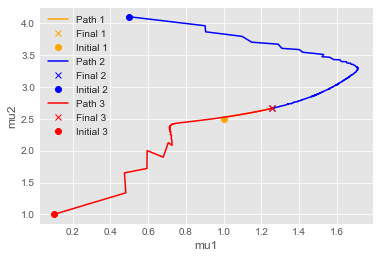

In [15]:
#plt.plot(param1[:,1],param1[:,2])

## sequence 1
n1 = len(param1)-1
plt.plot(param1[:,1],param1[:,2],color='orange',label="Path 1")
plt.plot(param1[n1,1],param1[n1,2],'x',color='orange',label="Final 1")
plt.plot(param1[0,1],param1[0,2],'o',color='orange',label="Initial 1")
## sequence 2
n2 = len(param2)-1
plt.plot(param2[:,1],param2[:,2],color='blue',label="Path 2")
plt.plot(param2[n2,1],param2[n2,2],'x',color='blue',label="Final 2")
plt.plot(param2[0,1],param2[0,2],'o',color='blue',label="Initial 2")
## sequence 3
n3 = len(param3)-1
plt.plot(param3[:,1],param3[:,2],color='red',label="Path 3")
plt.plot(param3[n3,1],param3[n3,2],'x',color='red',label="Final 3")
plt.plot(param3[0,1],param3[0,2],'o',color='red',label="Initial 3")
plt.xlabel("mu1")
plt.ylabel("mu2")
leg = plt.legend(loc='upper left')
plt.show()

## Problem 3


In [16]:
# Values given in the textbook
alpha = 0.3
mu1 = 1
mu2 = 2.5

In [17]:
def Ez(alpha,mu1,mu2,k):
    term1 = alpha*np.exp(-mu1)*np.power(mu1,k)
    term2 = (1-alpha)*np.exp(-mu2)*np.power(mu2,k)
    return term1/(term1+term2)

In [18]:
# Check function
Ez_vec = np.array(list(map(lambda y: Ez(alpha,mu1,mu2,y), np.arange(10))))
Ez_vec

array([6.57619125e-01, 4.34481758e-01, 2.35073895e-01, 1.09469629e-01,
       4.68661004e-02, 1.92888357e-02, 7.80587401e-03, 3.13704202e-03,
       1.25718311e-03, 5.03252852e-04])

In [19]:
# Run EM algorithm
def em_alg(alpha,mu1,mu2,X,para_tol,like_tol):
    old_like = -np.inf
    like_diff = np.inf
    iter_count = 0
    para_diff = np.inf

    while para_diff > para_tol or like_diff > like_tol:
        mu1_old = mu1
        mu2_old = mu2
        alpha_old = alpha
        Ez_vec = np.array(list(map(lambda y: Ez(alpha,mu1,mu2,y), np.arange(10))))
        alpha = sum(X*Ez_vec)/sum(X)
        mu1 = sum(X*np.arange(10)*Ez_vec)/sum(X*Ez_vec)
        mu2 = sum(X*np.arange(10)*(1-Ez_vec))/sum(X*(1-Ez_vec))
        # Check convergence
        para_diff = sum(np.absolute([alpha-alpha_old,mu1-mu1_old,mu2-mu2_old]))
        new_like = log_likelihood([alpha,mu1,mu2],X)
        like_diff = np.absolute(new_like-old_like)
        old_like = new_like
        iter_count = iter_count + 1
    return [alpha,mu1,mu2,iter_count,para_diff,like_diff]


In [20]:
em_out = em_alg(alpha,mu1,mu2,freq,10e-6,10e-6)

In [21]:
em_out[0:3] # matches textbook (0.3599, 1.2561, 2.6634)

[0.3593075138402641, 1.255089824982245, 2.662698781023993]

In [22]:
em_out[4:6]

[9.968900464174535e-06, 3.857394403894432e-08]

In [23]:
em_out[3]

1116

In [24]:
param1 = gradient_ascent(log_likelihood,gradient_log_likelihood,[alpha,mu1,mu2],freq,10e-6)
param1[1]

378

In [25]:
%timeit em_out = em_alg(alpha,mu1,mu2,freq,10e-6,np.inf) # No likelihood tolerance 

140 ms ± 599 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%timeit param1 = gradient_ascent(log_likelihood,gradient_log_likelihood,[alpha,mu1,mu2],freq,10e-6)

212 ms ± 440 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
em_steps = np.zeros(100)
for ii in np.arange(100):
    alpha = np.random.uniform(0,1,1)[0]
    mu1 = np.random.uniform(0,5,1)[0]
    mu2 = np.random.uniform(0,5,1)[0]
    em_steps[ii] = em_alg(alpha,mu1,mu2,freq,10e-6,np.inf)[3]

The EM algorithm seems to be a bit faster here. However this could be due to the implementation because it takes nearly 3 times as many iterations to converge (though we should not forget that the gradient ascent algorithm may do one or more halvings within each step). 